In [62]:
import matplotlib.pyplot as plt
import json

convert_float = lambda x: x.detach().cpu().to(torch.float32).numpy()

In [63]:
tokens_read = []
with open ('file_tokens.json', 'r') as fr:
    tokens_read = json.load(fr)

In [64]:
def rowwise_cosine_similarity(A, B):
    """Compute cosine similarity between corresponding rows of two matrices.
    
    Args:
        A: Tensor of shape [L, dim]
        B: Tensor of shape [L, dim]
    
    Returns:
        Tensor of shape [L] containing cosine similarities
    """
    # Normalize rows (L2 norm)
    A_norm = torch.nn.functional.normalize(A, p=2, dim=1)
    B_norm = torch.nn.functional.normalize(B, p=2, dim=1)
    
    # Compute dot product between corresponding rows
    return torch.einsum('ij,ij->i', A_norm, B_norm)  # Sum along dim axis

Text(0, 0.5, 'std of matrix diff')

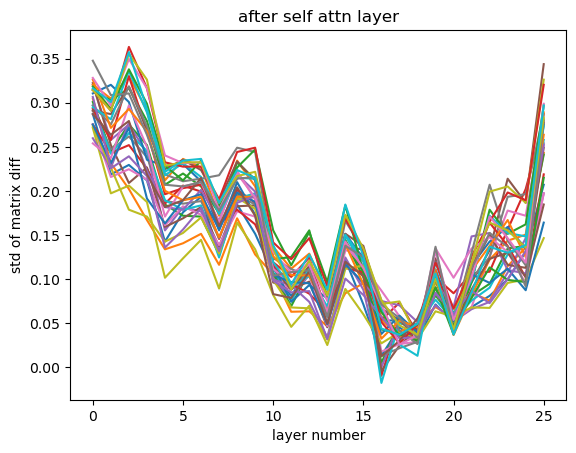

In [40]:
for ind in range(30):
    # plt.plot([convert_float((batch_attn_activations[ind][idx+1][0]
                            #   - batch_attn_activations[ind][idx][0]).abs().mean()) for idx in range(26)])
    plt.plot([convert_float(rowwise_cosine_similarity(batch_attn_activations[ind][idx+1][0][0]
                              , batch_attn_activations[ind][idx][0][0]).mean()) for idx in range(26)])
# rowwise_cosine_similarity
plt.xlabel('layer number')
plt.title('after self attn layer')
plt.ylabel('std of matrix diff')


Text(0, 0.5, 'std of matrix diff')

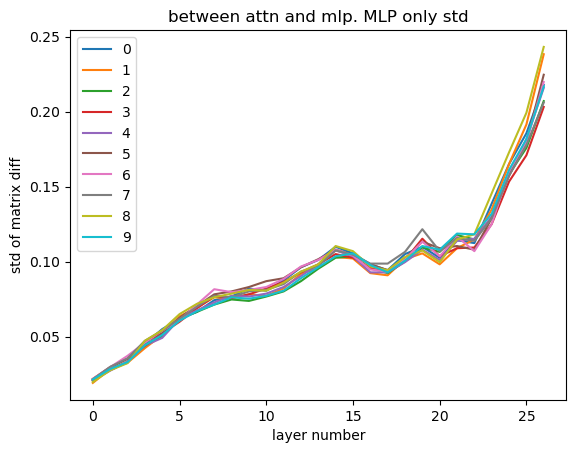

In [43]:
for ind in range(10):
    plt.plot([convert_float((batch_activations[ind][idx][0]
                              - batch_attn_activations[ind][idx][0]).abs().mean()) for idx in range(27)],
                                label=str(ind))
    # plt.plot([convert_float((batch_attn_activations[ind][idx][0]-batch_activations[ind][idx-1][0]).std())
    #            for idx in range(1, 27)], label=str(ind)+'_2')
    
    # plt.plot([convert_float(rowwise_cosine_similarity(batch_activations[ind][idx][0][0]
    #                           ,batch_attn_activations[ind][idx][0][0]).std()) for idx in range(27)],
    #                             label=str(ind))
    # plt.plot([convert_float((batch_attn_activations[ind][idx][0]-batch_activations[ind][idx-1][0]).std())
              #  for idx in range(1, 27)], label=str(ind)+'_2')
plt.legend()
    
plt.xlabel('layer number')
plt.title('between attn and mlp. MLP only std')
# plt.title('between attn and mlp. MLP and attn with suffix _2')
plt.ylabel('std of matrix diff')


Text(0, 0.5, 'std of matrix diff')

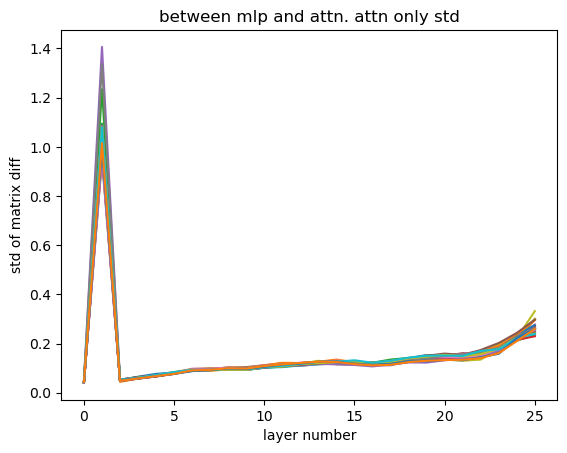

In [40]:
for ind in range(32):
    plt.plot([convert_float((batch_attn_activations[ind][idx][0]-batch_activations[ind][idx-1][0]).std())
               for idx in range(1, 27)])
plt.xlabel('layer number')
plt.title('between mlp and attn. attn only std')
plt.ylabel('std of matrix diff')


Text(0, 0.5, 'std of matrix diff')

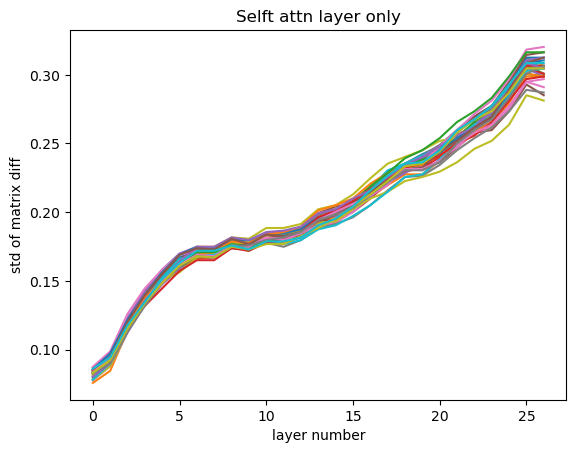

In [76]:
for ind in range(30):
    # plt.plot([convert_float((batch_attn_activations[ind][idx+1][0]
                            #   - batch_attn_activations[ind][idx][0]).abs().mean()) for idx in range(26)])
    plt.plot([convert_float((batch_attn_activations[ind][idx][0][0]-
                             batch_pre_attn_activations[ind][idx][0][0]
                             ).abs().mean()) for idx in range(27)])
# rowwise_cosine_similarity
plt.xlabel('layer number')
plt.title('Selft attn layer only')
plt.ylabel('std of matrix diff')

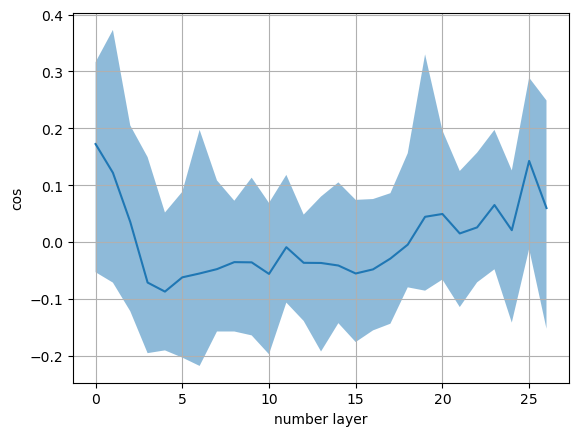

In [ ]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
lines = []
# pdist = nn.PairwiseDistance(p=100)
for ix in batch_activations:
    lines.append(np.array([torch.cosine_similarity(ix[f'layer_{str(i)}'], ix[f'layer_{str(i+1)}']).detach().cpu().to(torch.float32).numpy()[0] for i in range(27)]))
plt.plot(np.array(lines).mean(0))
# plt.plot(np.array(lines).std(0),color='r')
# plt.fill_between(np.arange(27), np.array(lines).std(0),color='r')
plt.fill_between(np.arange(27), np.array(lines).min(0), np.array(lines).max(0), alpha=0.5)
plt.xlabel('number layer')
plt.ylabel('cos')
plt.grid()
# plt.yscale('log')

# Common part

In [1]:
import matplotlib.pyplot as plt
import json

convert_float = lambda x: x.detach().cpu().to(torch.float32).numpy()

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# local_model_path = "/home/user31/polina/Llama-3.2-1B"
local_model_path = "/home/user31/polina/Llama-3.2-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    device_map="cuda:2",
    # load_in_4bit=True,            # активируем 4-bit квантование
    torch_dtype="auto"            # автоматически выбираем тип данных
)

tokenizer = AutoTokenizer.from_pretrained(local_model_path)

import torch
from logit_lens import logit_lens

from tqdm import tqdm
torch.cuda.is_available()


DEVICE = model.device
DEVICE

/home/user31/.conda/envs/tinyllama-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

device(type='cuda', index=2)

In [3]:
layer_to_remove = 21
model.model.layers = torch.nn.ModuleList(
    [layer for i, layer in enumerate(model.model.layers) 
     if i != layer_to_remove]
)

# Update config
model.config.num_hidden_layers -= 1

In [4]:
tokens_read = []
with open ('file_tokens_without_21.json', 'r') as fr:
    tokens_read = json.load(fr)

In [5]:
def rowwise_cosine_similarity(A, B):
    """Compute cosine similarity between corresponding rows of two matrices.
    
    Args:
        A: Tensor of shape [L, dim]
        B: Tensor of shape [L, dim]
    
    Returns:
        Tensor of shape [L] containing cosine similarities
    """
    # Normalize rows (L2 norm)
    A_norm = torch.nn.functional.normalize(A, p=2, dim=1)
    B_norm = torch.nn.functional.normalize(B, p=2, dim=1)
    
    # Compute dot product between corresponding rows
    return torch.einsum('ij,ij->i', A_norm, B_norm)  # Sum along dim axis

In [6]:
# Для хранения активаций
activations = {'input_layernorm': {i: [] for i in range(28)},
               'self_attn': {i: [] for i in range(28)},
               'post_attention_layernorm': {i: [] for i in range(28)},
               'mlp': {i: [] for i in range(28)}
               }

def get_activation(layer_name, name):
    global activations
    def hook(module, input, output):
        activations[name][layer_name].append(output[0].detach().cpu())  # берем только первый выход (обычно hidden_states)
    return hook

# Подписываемся на нужные слои в первом блоке декодера
layer_idx = 0  # можно изменить на любой другой слой
for layer_idx, layer in enumerate(model.model.layers):
    decoder_layer = model.model.layers[layer_idx]

    # Подписываем хуки
    decoder_layer.input_layernorm.register_forward_hook(get_activation(layer_idx, 'input_layernorm'))
    decoder_layer.self_attn.register_forward_hook(get_activation(layer_idx, 'self_attn'))
    decoder_layer.post_attention_layernorm.register_forward_hook(get_activation(layer_idx, 'post_attention_layernorm'))
    decoder_layer.mlp.register_forward_hook(get_activation(layer_idx, 'mlp'))

In [7]:
# Пример входного текста
# prompt = "The future of A.I is"

# Токенизируем
# inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Forward pass
with torch.no_grad():
    for _, token in tokens_read.items():
        
        outputs = model(
            input_ids=torch.tensor([token]).to(model.device),
            output_hidden_states=True
        )
        # break

In [13]:
from diff_graphics import visualize_heterogeneous_metrics, visualize_heterogeneous_metrics2

/home/user31/.conda/envs/tinyllama-env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user31/.conda/envs/tinyllama-env/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


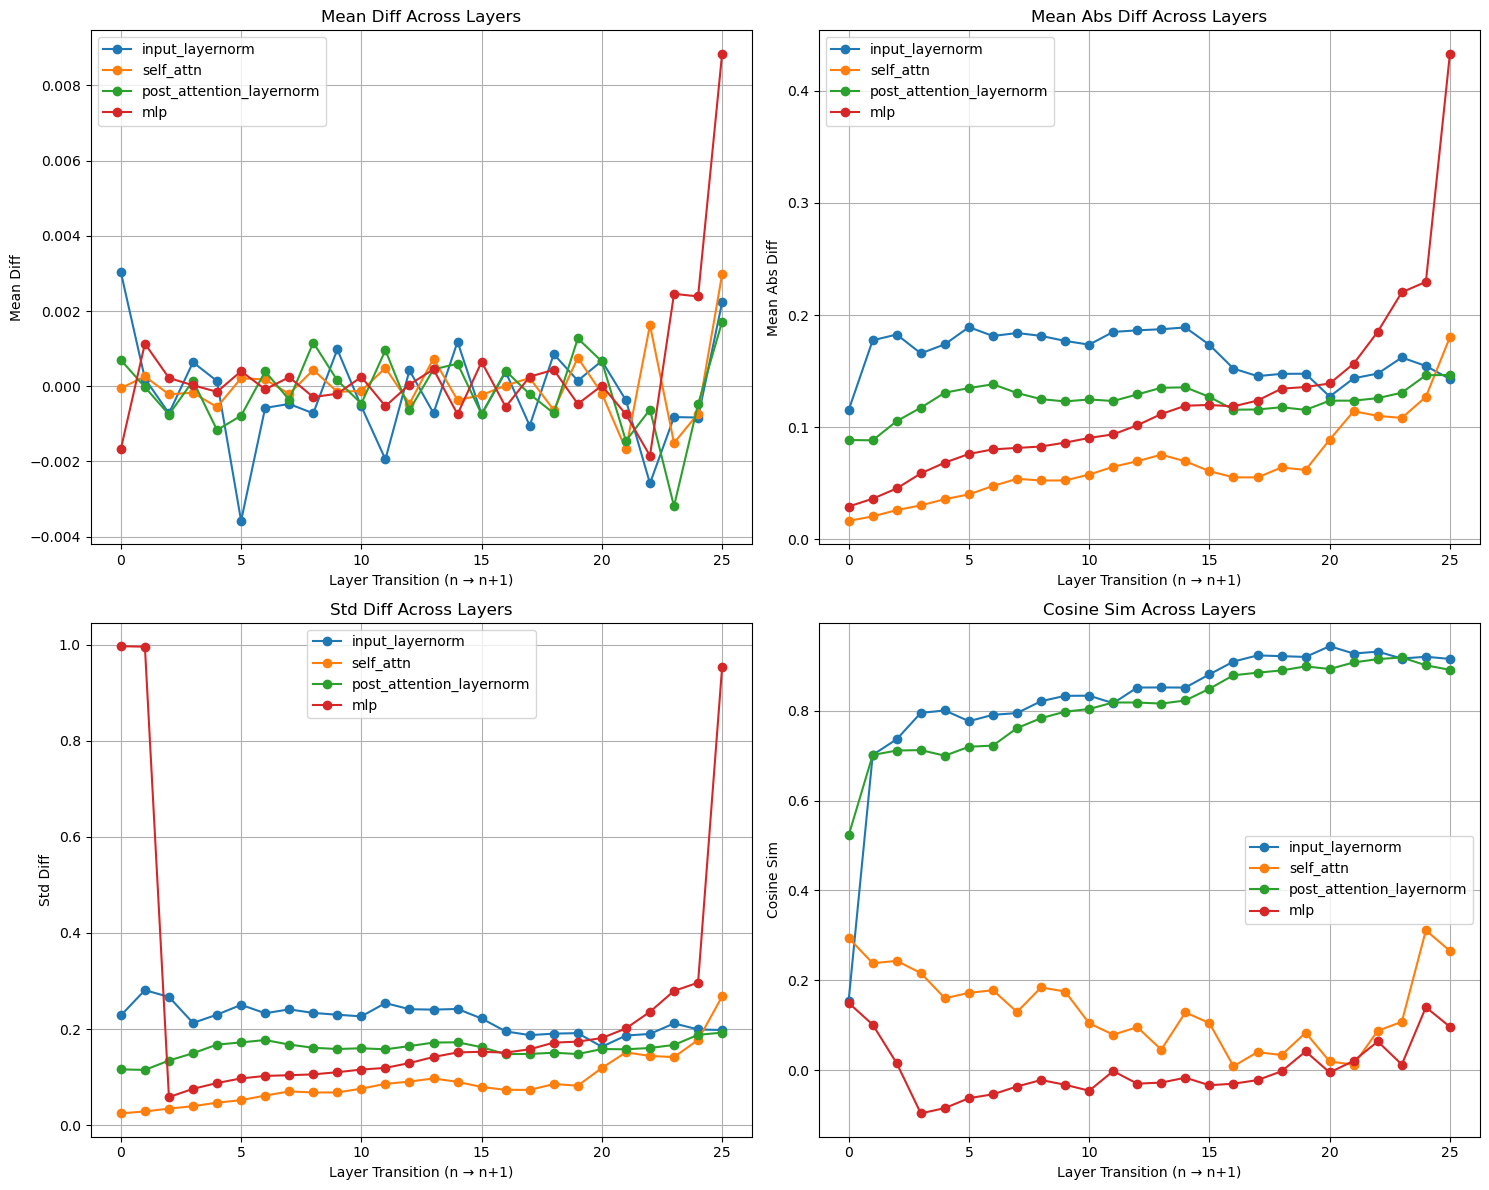

{'mean_diff': {'input_layernorm': [np.float32(0.00303187),
   np.float32(0.00020534763),
   np.float32(-0.0007210528),
   np.float32(0.0006384005),
   np.float32(0.00013733006),
   np.float32(-0.0035796177),
   np.float32(-0.00057535124),
   np.float32(-0.00047157303),
   np.float32(-0.00071985327),
   np.float32(0.0009799119),
   np.float32(-0.00053597114),
   np.float32(-0.0019436013),
   np.float32(0.0004223949),
   np.float32(-0.0007159086),
   np.float32(0.0011817039),
   np.float32(-0.0007458011),
   np.float32(0.00038203853),
   np.float32(-0.0010508796),
   np.float32(0.0008538517),
   np.float32(0.0001488218),
   np.float32(0.0006728404),
   np.float32(-0.00037273206),
   np.float32(-0.0025833216),
   np.float32(-0.00082017237),
   np.float32(-0.0008315782),
   np.float32(0.002230948),
   np.float64(nan)],
  'self_attn': [np.float32(-5.116466e-05),
   np.float32(0.00025949234),
   np.float32(-0.0002143238),
   np.float32(-0.00017156533),
   np.float32(-0.0005559473),
   np.flo

In [9]:
visualize_heterogeneous_metrics(activations)

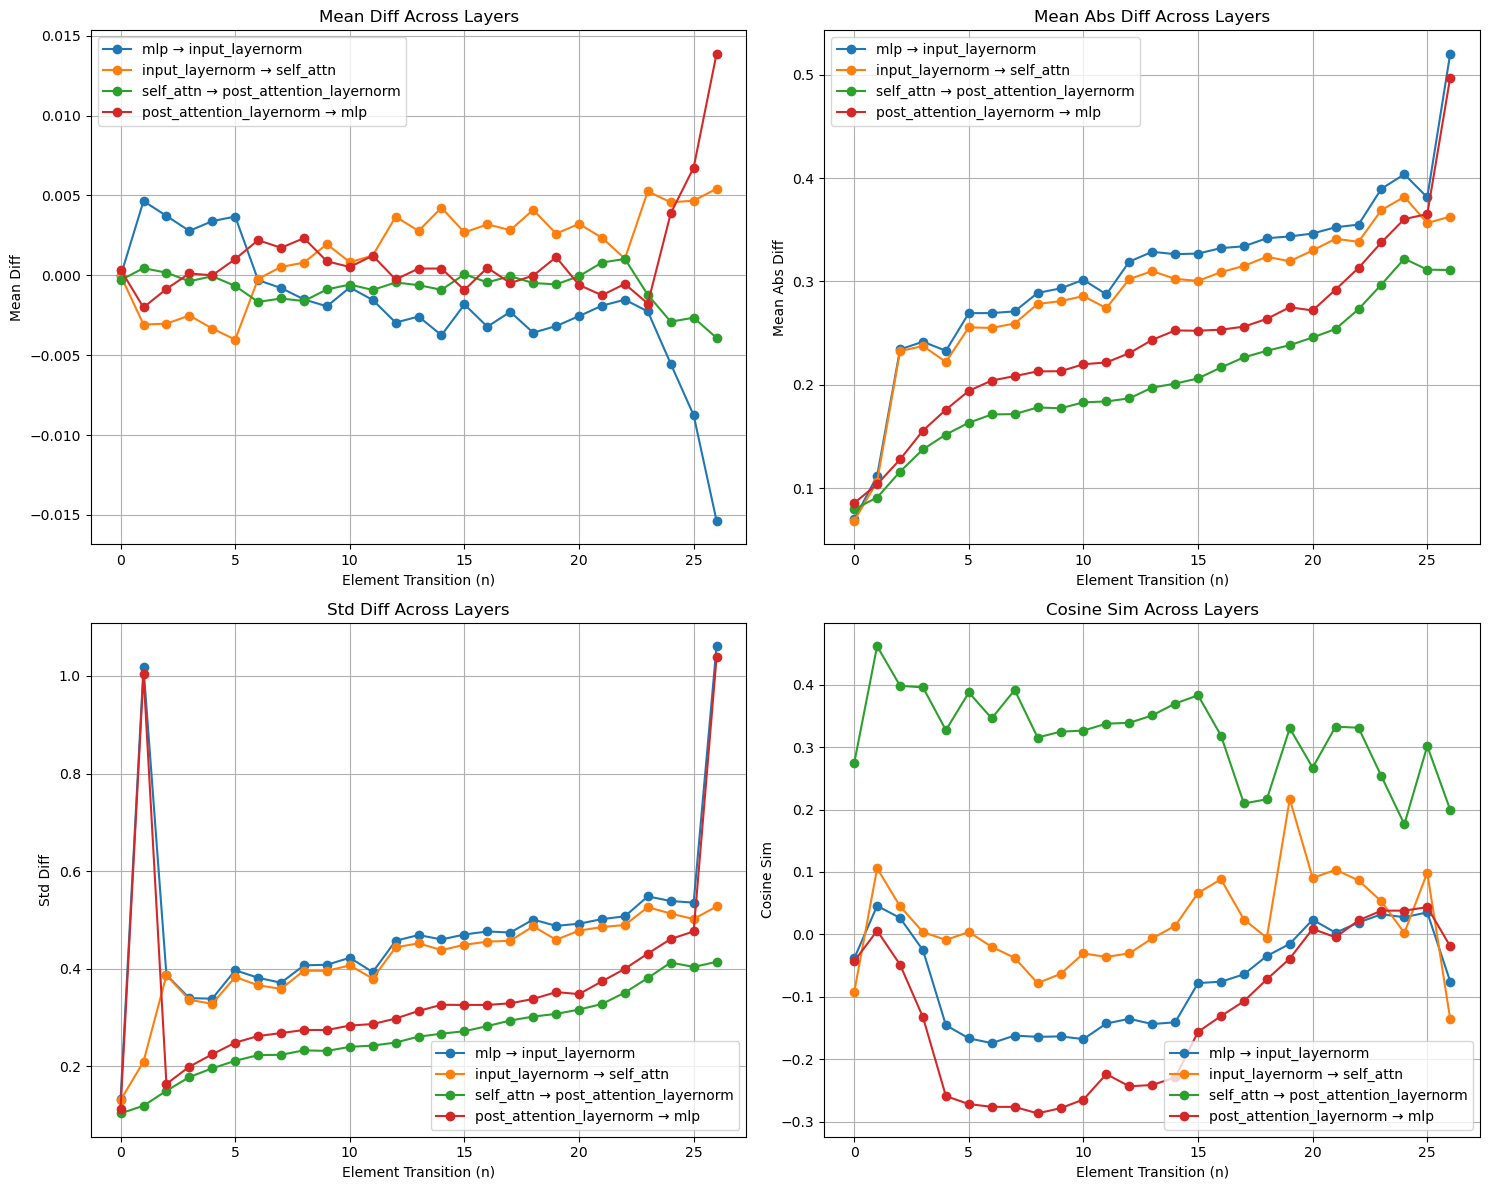

{'mean_diff': {'input_layernorm': [np.float32(-5.4324762e-05),
   np.float32(0.0046474533),
   np.float32(0.0037192076),
   np.float32(0.0027787816),
   np.float32(0.0033911723),
   np.float32(0.0036765388),
   np.float32(-0.00030244267),
   np.float32(-0.0007963429),
   np.float32(-0.001508319),
   np.float32(-0.0019415168),
   np.float32(-0.0007612438),
   np.float32(-0.0015448664),
   np.float32(-0.002958329),
   np.float32(-0.0025817794),
   np.float32(-0.0037480835),
   np.float32(-0.0018232586),
   np.float32(-0.0032175512),
   np.float32(-0.0022877152),
   np.float32(-0.0035927244),
   np.float32(-0.0031765779),
   np.float32(-0.0025567329),
   np.float32(-0.0019020373),
   np.float32(-0.0015276105),
   np.float32(-0.0022616764),
   np.float32(-0.0055393428),
   np.float32(-0.008759137),
   np.float32(-0.015371054)],
  'self_attn': [np.float32(1.0948891e-06),
   np.float32(-0.0030819396),
   np.float32(-0.0030277949),
   np.float32(-0.0025210665),
   np.float32(-0.003331032),
  

In [16]:
visualize_heterogeneous_metrics2(activations)